# Animal Image classification



## Introduction

This illustration demonstrates the process of performing image classification without utilizing pre-trained weights or a pre-built Keras Application model.
 
Instead, we begin with JPEG image files stored on disk and utilize the image_dataset_from_directory tool to create datasets. Additionally, we apply Keras image preprocessing layers to standardize the images and implement data augmentation.

## Setup

In [ ]:
#Import stuff

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np


#Mounting Google Drive for data

In [ ]:
#Data from google drive
#no can host files

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Downloading Data from Google Drive

The data is stored on Google Drive folder called ML-data.
The folder contains four following files:
"deer.zip, boar,zip, rabbit.zip, and fox.zip".
The files are from images.cv
Only thing that has been changed is zip file name.
The content of files is (near) identical

In [ ]:

#Copy google Drive Files
!cp -r drive/MyDrive/ML-Data/boar.zip /content
!cp -r drive/MyDrive/ML-Data/deer.zip /content
!cp -r drive/MyDrive/ML-Data/rabbit.zip /content
!cp -r drive/MyDrive/ML-Data/fox.zip /content
#Unzip files
!unzip -q boar.zip
!unzip -q deer.zip
!unzip -q fox.zip
!unzip -q rabbit.zip
#Remove zipped files
!rm boar.zip
!rm deer.zip
!rm fox.zip
!rm rabbit.zip
#rename folders
!mv images.cv_0gwh9fpn2s783pbq36a231i boar
!mv images.cv_7wop8x3wo6d11bhona19 fox
!mv images.cv_g30ja5h8edbs7laspqm8c9 rabbit
!mv images.cv_tgnukale54jxrnenvj7sns deer


#copy Google drive animal dataset into AnimalImages folder
!mkdir AnimalImages
!mkdir AnimalImages/wild_boar

#merge files
!cp -r boar/data/test/wild_boar/. AnimalImages/wild_boar/
!cp -r boar/data/train/wild_boar/. AnimalImages/wild_boar/
!cp -r boar/data/val/wild_boar/. AnimalImages/wild_boar/

!mkdir AnimalImages/fox

!cp -r fox/data/test/"animal fox"/. AnimalImages/fox/
!cp -r fox/data/train/"animal fox"/. AnimalImages/fox/
!cp -r fox/data/val/"animal fox"/. AnimalImages/fox/

!mkdir AnimalImages/deer
!cp -r deer/data/test/"animal deer"/. AnimalImages/deer/
!cp -r deer/data/train/"animal deer"/. AnimalImages/deer/
!cp -r deer/data/val/"animal deer"/. AnimalImages/deer/

!mkdir AnimalImages/rabbit
!cp -r rabbit/data/test/"animal rabbit"/. AnimalImages/rabbit/
!cp -r rabbit/data/train/"animal rabbit"/. AnimalImages/rabbit/
!cp -r rabbit/data/val/"animal rabbit"/. AnimalImages/rabbit/

#Remove extracted files
!rm -rf boar
!rm -rf deer
!rm -rf fox
!rm -rf rabbit


Now we have a `AnimalImages` folder which contain four subfolders, `Fox`,`Rabbit`, `Deer` and `Boar`. Each
 subfolder contains image files for each category.

In [ ]:
!ls AnimalImages

## Generate a `Dataset`

In [ ]:
image_size = (128, 128)
batch_size = 128

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "AnimalImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

print(train_ds.class_names)

Found 4137 files belonging to 4 classes.
Using 3310 files for training.
Using 827 files for validation.
['deer', 'fox', 'rabbit', 'wild_boar']


## Visualize the data

Here are the first 9 images in the training dataset. As you can see, label 1 is "dog"
and label 0 is "cat".

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

NameError: ignored

<Figure size 720x720 with 0 Axes>

## Using image data augmentation
Because our dataset isn't very large we are using artifical data augmentation.
The following code flips some images horizontally and Randomly rotates other images.

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

Let's visualize what the augmented samples look like, by applying `data_augmentation`
repeatedly to the first image in the dataset:

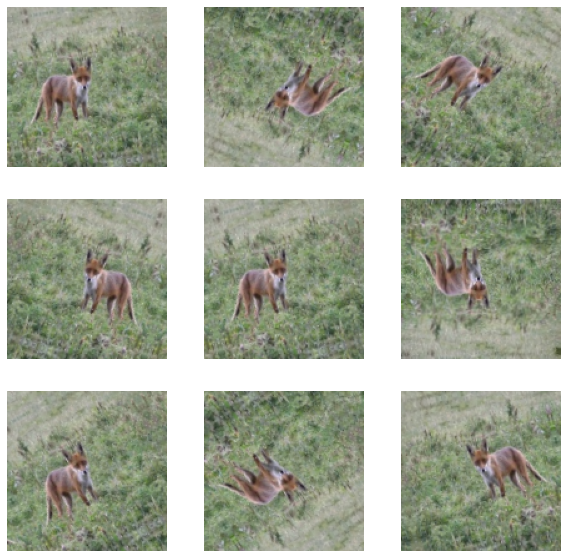

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## Standardizing the data

Our image are already in a standard size (180x180), as they are being yielded as
contiguous `float32` batches by our dataset. However, their RGB channel values are in
the `[0, 255]` range. This is not ideal for a neural network;
in general you should seek to make your input values small. Here, we will
standardize values to be in the `[0, 1]` by using a `Rescaling` layer at the start of
our model.

## Two options to preprocess the data

There are two ways you could be using the `data_augmentation` preprocessor:

**Option 1: Make it part of the model**, like this:

```python
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
...  # Rest of the model
```

With this option, your data augmentation will happen *on device*, synchronously
with the rest of the model execution, meaning that it will benefit from GPU
acceleration.

Note that data augmentation is inactive at test time, so the input samples will only be
augmented during `fit()`, not when calling `evaluate()` or `predict()`.

If you're training on GPU, this may be a good option.

**Option 2: apply it to the dataset**, so as to obtain a dataset that yields batches of
augmented images, like this:

```python
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))
```

With this option, your data augmentation will happen **on CPU**, asynchronously, and will
be buffered before going into the model.

If you're training on CPU, this is the better option, since it makes data augmentation
asynchronous and non-blocking.

In our case, we'll go with the second option. If you're not sure
which one to pick, this second option (asynchronous preprocessing) is always a solid choice.

## Configure the dataset for performance

Let's apply data augmentation to our training dataset,
and let's make sure to use buffered prefetching so we can yield data from disk without
having I/O becoming blocking:

In [ ]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


## Build a model

We'll build a small version of the Xception network. We haven't particularly tried to
optimize the architecture; if you want to do a systematic search for the best model
configuration, consider using
[KerasTuner](https://github.com/keras-team/keras-tuner).

Note that:

- We start the model with the `data_augmentation` preprocessor, followed by a
 `Rescaling` layer.
- We include a `Dropout` layer before the final classification layer.

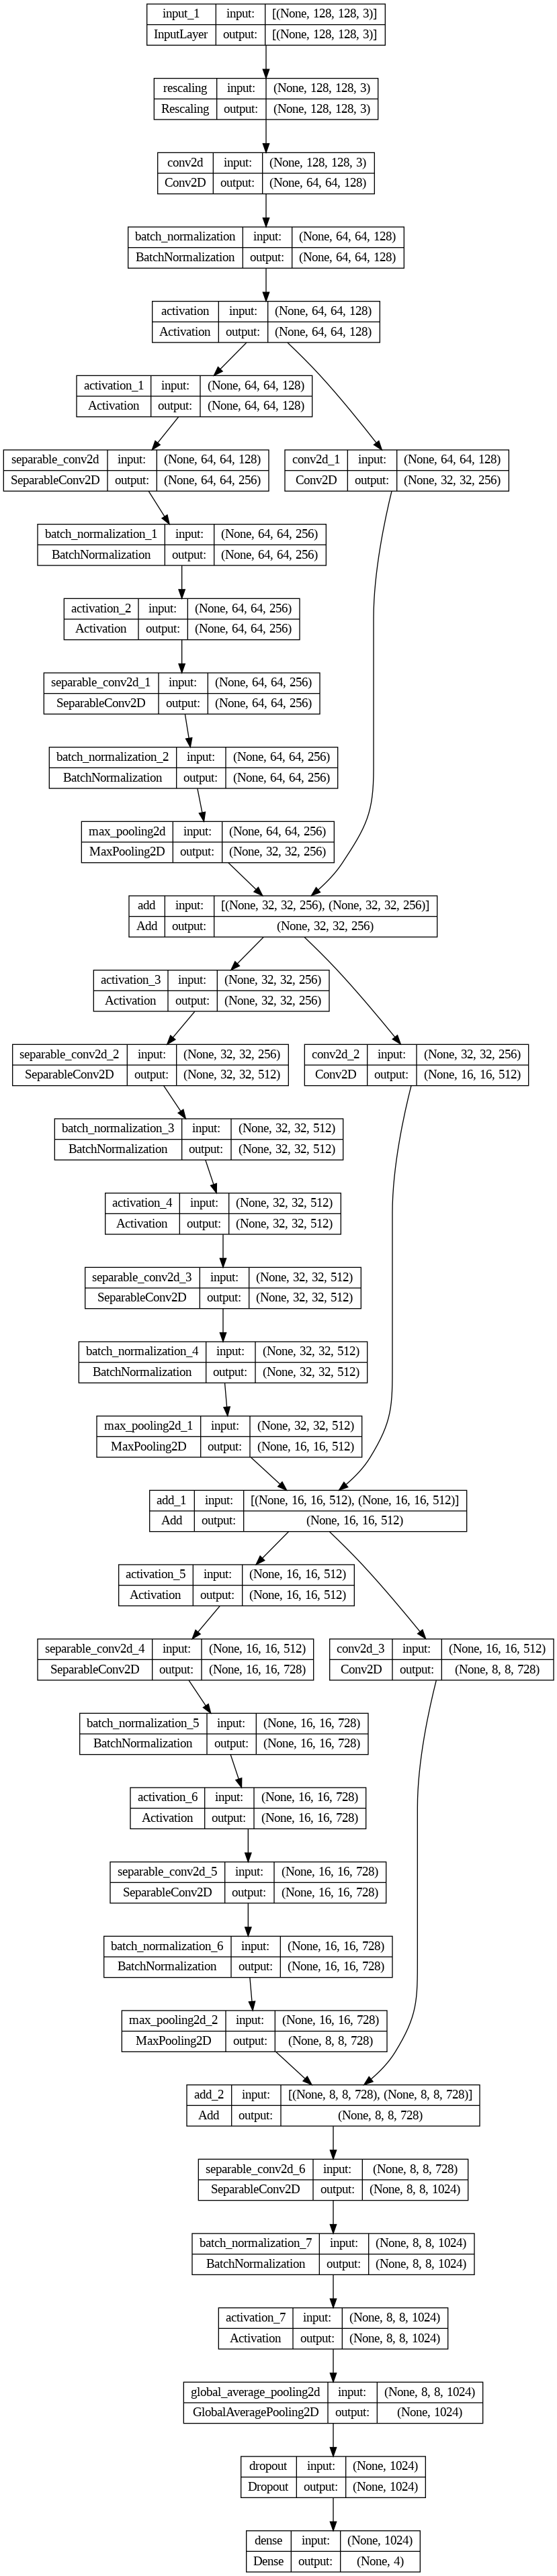

In [ ]:

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=4)
keras.utils.plot_model(model, show_shapes=True)

## Train the model

In [ ]:
epochs = 15

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)


Epoch 1/15
26/26 [==============================] - 26s 697ms/step - loss: 0.5963 - accuracy: 0.7740 - val_loss: 1.3334 - val_accuracy: 0.3676
Epoch 2/15
26/26 [==============================] - 18s 670ms/step - loss: 0.4055 - accuracy: 0.8514 - val_loss: 1.2948 - val_accuracy: 0.3906
Epoch 3/15
26/26 [==============================] - 17s 641ms/step - loss: 0.2758 - accuracy: 0.9060 - val_loss: 1.2406 - val_accuracy: 0.4728
Epoch 4/15
26/26 [==============================] - 17s 645ms/step - loss: 0.1829 - accuracy: 0.9414 - val_loss: 1.2056 - val_accuracy: 0.4716
Epoch 5/15
26/26 [==============================] - 17s 661ms/step - loss: 0.1107 - accuracy: 0.9677 - val_loss: 1.2135 - val_accuracy: 0.4583
Epoch 6/15
26/26 [==============================] - 18s 669ms/step - loss: 0.0849 - accuracy: 0.9755 - val_loss: 1.1294 - val_accuracy: 0.5345
Epoch 7/15
26/26 [==============================] - 17s 653ms/step - loss: 0.0517 - accuracy: 0.9885 - val_loss: 1.0643 - val_accuracy: 0.5768

We get to >90% validation accuracy after training for 25 epochs on the full dataset
(in practice, you can train for 50+ epochs before validation performance starts degrading).

In [ ]:
!unzip drive/MyDrive/Kõigeuuem.zip

Archive:  drive/MyDrive/Kõigeuuem.zip
   creating: content/new_model/
   creating: content/new_model/assets/
  inflating: content/new_model/saved_model.pb  
 extracting: content/new_model/fingerprint.pb  
  inflating: content/new_model/keras_metadata.pb  
   creating: content/new_model/variables/
  inflating: content/new_model/variables/variables.data-00000-of-00001  
  inflating: content/new_model/variables/variables.index  


In [ ]:
model.save("kõige_täpsem_mudel")
!zip -r kõige_täpsem_mudel.zip /content/kõige_täpsem_mudel/

  adding: content/kõige_täpsem_mudel/ (stored 0%)
  adding: content/kõige_täpsem_mudel/assets/ (stored 0%)
  adding: content/kõige_täpsem_mudel/saved_model.pb (deflated 90%)
  adding: content/kõige_täpsem_mudel/fingerprint.pb (stored 0%)
  adding: content/kõige_täpsem_mudel/keras_metadata.pb (deflated 94%)
  adding: content/kõige_täpsem_mudel/variables/ (stored 0%)
  adding: content/kõige_täpsem_mudel/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/kõige_täpsem_mudel/variables/variables.index (deflated 74%)


## Run inference on new data

Note that data augmentation and dropout are inactive at inference time.

In [ ]:
#load model 
model = keras.models.load_model('content/new_model')

image_size = (128,128)


In [ ]:


img = keras.preprocessing.image.load_img(
    "drive/MyDrive/Jassu.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis
predictions = model.predict(img_array)
print(train_ds.class_names[np.argmax(predictions[0])])
print(train_ds.class_names)
numbers = predictions[0]
for i in range(len(train_ds.class_names)):
  print(train_ds.class_names[i] ," : ", round(numbers[i].astype(float)* 100, 2) , "%")


1/1 [==============================] - 0s 23ms/step
fox
['deer', 'fox', 'rabbit', 'wild_boar']
deer  :  0.02 %
fox  :  95.54 %
rabbit  :  0.24 %
wild_boar  :  4.19 %
